In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import os
from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential,load_model,save_model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

Age Estimation

In [22]:
# image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50') #tell python in which directory the training images are.
image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50')

In [23]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [24]:
image_df = images.sample(20000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [25]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [26]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', # kepek
    y_col='Age', # becsülendő életkorok
    target_size=(120, 120), # egy kép mérete
    color_mode='rgb', # 3 csatornás képek, RGB
    class_mode='raw', # mivel a célváltozónk int típusú és nem object
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 11200 validated image filenames.
Found 2800 validated image filenames.
Found 6000 validated image filenames.


In [27]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

age_model = tf.keras.Model(inputs=inputs, outputs=outputs)

age_model.compile(
    optimizer='adam',
    loss='mse'
)

history = age_model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
350/350 [==============================] - 2724s 8s/step - loss: 129.8511 - val_loss: 50.8529
Epoch 2/10
350/350 [==============================] - 35s 100ms/step - loss: 50.1404 - val_loss: 50.6266
Epoch 3/10
350/350 [==============================] - 36s 103ms/step - loss: 49.8209 - val_loss: 50.6234
Epoch 4/10
350/350 [==============================] - 36s 102ms/step - loss: 49.6867 - val_loss: 51.3830
Epoch 5/10
350/350 [==============================] - 37s 106ms/step - loss: 50.1204 - val_loss: 51.5209
Epoch 6/10
350/350 [==============================] - 35s 101ms/step - loss: 49.3719 - val_loss: 50.0230
Epoch 7/10
350/350 [==============================] - 35s 99ms/step - loss: 49.6227 - val_loss: 49.9245
Epoch 8/10
350/350 [==============================] - 34s 97ms/step - loss: 49.1917 - val_loss: 50.0658
Epoch 9/10
350/350 [==============================] - 34s 98ms/step - loss: 49.4390 - val_loss: 51.7156
Epoch 10/10
350/350 [==============================] - 35s

Gender Estimation

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI/.kaggle/"

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [13]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [14]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/AI/.kaggle/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( '/content/drive/MyDrive/AI/.kaggle/Dataset/Validation',
# validation_generator =  test_datagen.flow_from_directory( '/content/drive/MyDrive/AI/.kaggle/Dataset/Test',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 73989 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [15]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [18]:
# Building Model
gender_model=Sequential()
gender_model.add(base_model)
gender_model.add(layers.Dropout(.2))

gender_model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
gender_model.add(BatchNormalization())
gender_model.add(layers.Dropout(.1))
gender_model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
gender_model.add(BatchNormalization())
gender_model.add(layers.Dropout(.1))
gender_model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
gender_model.add(BatchNormalization())
gender_model.add(layers.Dropout(.1))
gender_model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
gender_model.add(BatchNormalization())
gender_model.add(layers.Dropout(.1))
gender_model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
gender_model.add(BatchNormalization())
gender_model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
gender_model.add(Flatten())
gender_model.add(Dense(FC , activation='relu'))
gender_model.add(layers.Dropout(.2))
gender_model.add(Dense(FC , activation='relu'))
gender_model.add(layers.Dropout(.2))
gender_model.add(Dense(FC, activation='relu'))
gender_model.add(layers.Dropout(.2))
gender_model.add(Dense(E, activation='sigmoid'))

gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [19]:
gender_model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [20]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [21]:
%time
hist = gender_model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


<ipython-input-21-d18af231c198>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = gender_model.fit_generator(generator=train_generator,


Epoch 1/8
256/256 [==============================] - 139s 487ms/step - loss: 0.3356 - accuracy: 0.9027 - val_loss: 1.3900 - val_accuracy: 0.3912 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 128s 500ms/step - loss: 0.2647 - accuracy: 0.9089 - val_loss: 3.5751 - val_accuracy: 0.3931 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 118s 461ms/step - loss: 0.2425 - accuracy: 0.9125 - val_loss: 1.2618 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 110s 429ms/step - loss: 0.2323 - accuracy: 0.9147 - val_loss: 4.2066 - val_accuracy: 0.3895 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - 108s 422ms/step - loss: 0.2282 - accuracy: 0.9169 - val_loss: 0.7645 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 6/8
256/256 [==============================] - 107s 417ms/step - loss: 0.1628 - accuracy: 0.9432 - val_loss: 2.0209 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 7/8
256/256 [==============================] -

After Train

In [29]:
predicted_ages = np.squeeze(age_model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(age_model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

188/188 [==============================] - 1101s 6s/step
     Test RMSE: 6.97106
Test R^2 Score: -0.01247


In [30]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 6.92800


1/1 [==============================] - 0s 20ms/step


Predicted: 31
Actual: 25
This  is a female


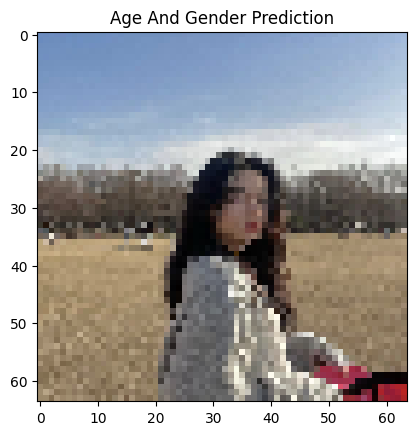

In [35]:
import matplotlib.pyplot as plt

test_image = '/content/drive/MyDrive/AI/AI_Project/FaceTest/test1.jpg'
image = tf.keras.preprocessing.image.load_img(test_image, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(image)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = gender_model.predict(images, batch_size=1)

plt.figure()
plt.imshow(image)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(25)

plt.title("Age And Gender Prediction")

print('\n\nPredicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")

plt.show()